# End-to-end Privacy Preserving Training and Inference on Medical Data 

## Introduction
In this tutorial, we will demonstrate the process of privacy-preserving training using Fed-BioMed, which leverages federated learning with secure aggregation. Subsequently, we will deploy the final model obtained through federated learning in a privacy-preserving manner using the [Concrete-ML](https://github.com/zama-ai/concrete-ml) library. This approach allows us to achieve privacy-preserving inference through a software-as-a-service (SaaS) model.

The selected dataset originates from a medical task assigned by [Flamby](https://github.com/owkin/FLamby), specifically the FedHeart Disease dataset. For more detailed information about the dataset, please refer to the provided [link](https://github.com/owkin/FLamby/blob/main/flamby/datasets/fed_heart_disease/README.md).

## Install Concrete-ML

This tutorial assumes you have Concrete-ML installed in your Fed-BioMed researcher environment. 

If needed, you may install it with:
 `pip install concrete-ml`

### Note for MacOS users with ARM chips

If you have a recent Mac machine with Apple Silicon (ARM chips), then you may experience kernel failure in Section 3.2 of this notebook. 

To overcome this issue, you need to rebuild your conda environment with a native python executable, before installing Concrete-ML.

After setting `export CONDA_SUBDIR=osx-arm64` you can re install `fedbiomed` and Concrete-ML.


## Task: identify patients with heart disease

We rely on the FedHeart dataset and task from [FLamby](https://github.com/owkin/FLamby), in which tabular patient data as input is used to predict the presence or absence of heart disease. More details can be found in FLamby's [paper](https://openreview.net/pdf?id=GgM5DiAb6A2).

### FLamby configuration - Download FedHeart

You need to download the FLamby dataset that we will use. For licensing reasons, these are not included directly in the FLamby installation.

To download the fed_heart dataset in `${FEDBIOMED_DIR}/data` (where `${FEDBIOMED_DIR}` is the base directory of Fed-BioMed): 

1. `pip install wget`<br>
2. `python ${FEDBIOMED_DIR}/docs/tutorials/concrete-ml/download.py --output-folder ${FEDBIOMED_DIR}/data`

In [ ]:
import os
import torch 
from torch.utils.data import DataLoader
import numpy as np
from fedbiomed.common.training_plans import TorchTrainingPlan
from flamby.datasets.fed_heart_disease import FedHeartDisease
from fedbiomed.common.data import FlambyDataset, DataManager
from concrete.ml.torch.compile import compile_torch_model
from torch.nn.modules.loss import _Loss
import torch.nn as nn
from fedbiomed.researcher.config import config
tensorboard_dir = config.vars['TENSORBOARD_RESULTS_DIR']

In [ ]:
FEDBIOMED_DIR = os.getenv('FEDBIOMED_DIR')
DATASET_TEST_PATH = f"{FEDBIOMED_DIR}/data"

## 1. Fed-BioMed

Configuring the Fed-BioMed training plan involves specifying the machine learning model, defining the loss function, and identifying the necessary dependencies. This ensures a clear and well-defined setup for the training process.

In [ ]:
%load_ext tensorboard

In [ ]:
class FedHeartTrainingPlan(TorchTrainingPlan):
    
    class Baseline(nn.Module):
        
        def __init__(self):
            super().__init__()
            self.fc1 = nn.Linear(13, 16)
            self.fc2 = nn.Linear(16, 2)
            self.act = nn.LeakyReLU()
        def forward(self, x):
            x = self.act(self.fc1(x))
            x = self.fc2(x)
            return x
        
    class BaselineLoss(_Loss):
        def __init__(self):
            super().__init__()
            self.ce = torch.nn.CrossEntropyLoss()

        def forward(self, prediction: torch.Tensor, target: torch.Tensor):
            target = torch.squeeze(target, dim=1).type(torch.long)
            return self.ce(prediction, target)
    
    def init_model(self, model_args):
        return self.Baseline()

    def init_optimizer(self, optimizer_args):
        return torch.optim.AdamW(self.model().parameters(), lr=optimizer_args["lr"])

    def init_dependencies(self):
        return ["from flamby.datasets.fed_heart_disease import FedHeartDisease",
                "from torch.nn.modules.loss import _Loss",
                "from fedbiomed.common.data import FlambyDataset, DataManager"]

    def training_step(self, data, target):
        logits = self.model().forward(data)
        return self.BaselineLoss().forward(logits, target)

    def training_data(self, batch_size=2):
        dataset = FlambyDataset()
        train_kwargs = {'batch_size': batch_size, 'shuffle': True}
        return DataManager(dataset, **train_kwargs)

In [ ]:
batch_size = 8
num_updates = 10
num_rounds = 50

In [ ]:
training_args = {
    'optimizer_args': {
        'lr': 5e-4,
    },
    'loader_args': {
        'batch_size': batch_size,
    },
    'num_updates': num_updates,
    'dry_run': False,
    'log_interval': 2,
    'test_ratio' : 0.0,
    'test_on_global_updates': False,
    'test_on_local_updates': False,
    'random_seed':42,
}

model_args = {}

## 2. Federated Learning Training with SecAgg

**Nodes Configuration:**
The FLamby Fed-Heart benchmark relies on 4 nodes.
For each node in the range `i in [0...3]` (`0` and `3` are both included):

1. Open a new terminal.
2. Run the command: `fedbiomed node --path my-node-{i} dataset add`
3. Select `6) flamby`.
4. Enter the dataset name: `flamby` (optional).
5. Set tags to: `heart` (important).
6. Description: Enter `none` (optional).
7. Select `1) fed_heart_disease`.
8. Specify a center ID between 0 and 3: `{i}`.
9. Description: Enter `none` (optional).
10. Run the command: `fedbiomed node --path my-node-{i}.ini start`.



In [ ]:
from fedbiomed.researcher.experiment import Experiment
from fedbiomed.researcher.aggregators.fedavg import FedAverage

tags =  ['heart']

exp_sec_agg = Experiment(tags=tags,
                 training_plan_class=FedHeartTrainingPlan,
                 training_args=training_args,
                 model_args=model_args,
                 round_limit=num_rounds,
                 aggregator=FedAverage(),
                 secagg=True,
                 tensorboard=True
                )

In [ ]:
tensorboard --logdir "$tensorboard_dir"

In our example, the training loss curve for the 4 nodes looks like this:
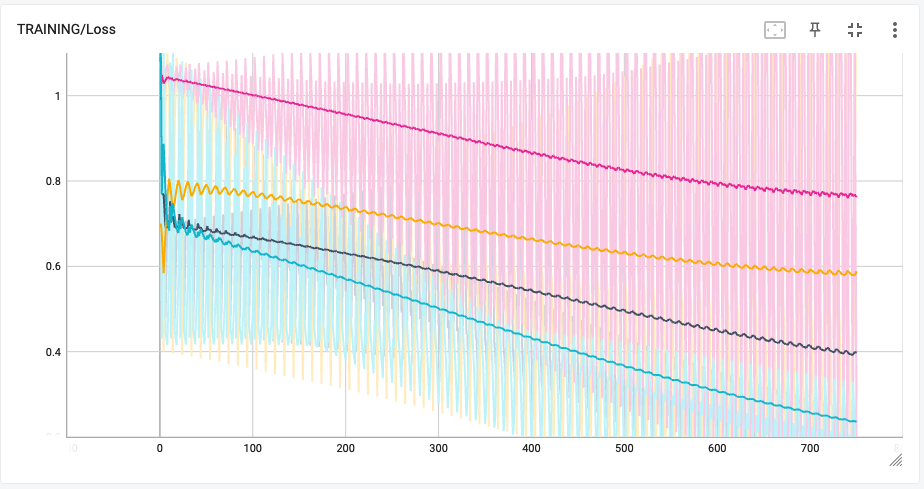

In [ ]:
exp_sec_agg.run()

## 3. Inference

We now have access to the weights of the final model, after secure encrypted training.

In [ ]:
fed_sec_agg_model = exp_sec_agg.training_plan().model()
fed_sec_agg_model.eval()

In [ ]:
test_dataset = FedHeartDisease(center=0,pooled=True, train=False, data_path=DATASET_TEST_PATH)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 3.1. Inference with torch using the plaintext model

First, we establish a baseline by evaluating the plaintext (unencrypted) model on a held-out test dataset.

In [ ]:
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        logits = torch.sigmoid(net(data))
        output = logits.argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy over plaintext model: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


In [ ]:
test_torch(fed_sec_agg_model, test_dataloader)

In our example we reach an accuracy over the plaintext model of 77.56%

### 3.2. Inference with Concrete-ML using the encrypted model

Using Zama's [Concrete-ML](https://github.com/zama-ai/concrete-ml) library, we now show that a similar performance can be achieved by performing inference on the encrypted model. 

We have therefore achieved fully secure, end-to-end encrypted training and inference. 

In [ ]:
def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    # Casting the inputs into int64 is recommended
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in test_loader:
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        logits = torch.tensor(quantized_module.forward(data, fhe=fhe_mode), requires_grad=False)

        endidx = idx + target.shape[0]

        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = torch.sigmoid(logits).argmax(1).numpy()
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy over encrypted model: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


In [ ]:
# concrete ml is using the traceback, 
# while fed-biomed for logging reasons fixs it to 3, to use concrete-ml we reset to the default value
import sys
sys.tracebacklimit = 1000

In [ ]:
n_bits = 6
compile_set = np.random.randint(0, 10, (100, 13)).astype(float)
q_module = compile_torch_model(fed_sec_agg_model, compile_set, rounding_threshold_bits=6)

In [ ]:
test_with_concrete(q_module, test_dataloader, True)

In our example we reach an accuracy over the encrypted model of 76.38%

The loss of accuracy due to encryption during inference is neglectable!